In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [2]:
'''

ML 기말 프로젝트 base model 자리에 있질 않네 아주주

* 모델 구조 변경으로 인한 성능 향상은 평가에서 제외.
  구조 변경 예시) Conv & Linear layer 추가

'''

class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.conv1_M = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True))

        self.conv2_M = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True))

        self.conv3_M = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))

        self.conv4_M = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))

        self.GAP = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv1_M(out)

        out = self.conv2(out)
        out = self.conv2_M(out)

        out = self.conv3(out)
        out = self.conv3_M(out)

        out = self.conv4(out)
        out = self.conv4_M(out)

        out = self.conv5(out)
        out = self.GAP(out)
        # 해당 위치 out : classifier 직전 layer의 feature --

        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


In [3]:

# # train과 test 데이터 디렉토리 경로 설정
train_dir = '/home/gidaseul/Documents/GitHub/ML_2/datas/MNIST/train'
test_dir = '/home/gidaseul/Documents/GitHub/ML_2/datas/MNIST/test'

# 데이터 전처리: MNIST 이미지를 RGB 채널로 처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 입력 크기를 모델에 맞게 조정 (BaseModel은 32x32 크기 가정)
    transforms.ToTensor(),        # 이미지를 텐서로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB 정규화
])

# 데이터셋 로드
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# 데이터셋 크기 확인
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# 데이터 클래스 확인
print(f"Classes: {train_dataset.classes}")


Number of training samples: 450
Number of test samples: 50
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [4]:
# class PadToSquare(object):
#     """이미지 크기를 최대 크기로 패딩하여 정사각형으로 만듭니다."""
#     def __init__(self, padding_value=0):
#         self.padding_value = padding_value
#         self.to_tensor = transforms.ToTensor()  # PIL 이미지 -> Tensor
#         self.to_pil = transforms.ToPILImage()  # Tensor -> PIL 이미지

#     def __call__(self, image):
#         # PIL 이미지를 텐서로 변환
#         image_tensor = self.to_tensor(image)

#         # 현재 이미지 크기 가져오기
#         _, height, width = image_tensor.shape
#         max_size = max(height, width)

#         # 패딩 계산 (좌, 상, 우, 하)
#         padding = (0, 0, max_size - width, max_size - height)  # (left, top, right, bottom)

#         # 패딩 추가 (텐서에 패딩)
#         padded_tensor = F.pad(image_tensor, padding, value=self.padding_value)

#         # 텐서를 다시 PIL 이미지로 변환
#         padded_image = self.to_pil(padded_tensor)
#         return padded_image

# # 데이터 디렉토리 설정
# train_dir = '/home/gidaseul/Documents/GitHub/ML_2/datas/SportsBall/train'
# test_dir = '/home/gidaseul/Documents/GitHub/ML_2/datas/SportsBall/test'

# # 데이터 전처리: MNIST 이미지를 RGB 채널로 처리
# transform = transforms.Compose([
#     PadToSquare(),  # 이미지 크기를 가장 큰 크기로 맞추기 위해 패딩
#     transforms.Resize((228, 228)),
#     transforms.ToTensor(),        # 이미지를 텐서로 변환
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB 정규화
# ])

# # 데이터셋 로드
# train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
# test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# # DataLoader 생성
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# # 데이터셋 크기 확인
# print(f"Number of training samples: {len(train_dataset)}")
# print(f"Number of test samples: {len(test_dataset)}")

# # 데이터 클래스 확인
# print(f"Classes: {train_dataset.classes}")


In [5]:

# 모델, 손실 함수, 옵티마이저 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BaseModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# 조기 종료 파라미터 설정
early_stopping_patience = 10  # 개선되지 않으면 5 에폭 후 종료
best_test_loss = float('inf')  # 최적의 검증 손실
patience_counter = 0  # 개선되지 않은 에폭 수 카운트

# Feature map 추출을 위한 forward hook 등록
features = []

def hook_fn(module, input, output):
    features.append(output.cpu().detach().numpy())

hook = model.GAP.register_forward_hook(hook_fn)

# 수정된 Feature 추출 함수 (불필요한 글로벌 변수 제거)
def extract_features(model, loader, device):
    features, labels_list = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            # GAP 레이어를 통해 Latent Feature 추출
            latent = model.GAP(model.conv5(model.conv4(model.conv3(model.conv2(model.conv1(images))))))
            latent = latent.view(latent.size(0), -1)
            features.append(latent.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
    features = np.concatenate(features, axis=0)
    return features, np.array(labels_list)

def plot_tsne(features, labels, num_classes=10):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    for class_idx in range(num_classes):
        idx = labels == class_idx
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=f'Class {class_idx}', alpha=0.6)
    plt.legend()
    plt.title("t-SNE Visualization of Features")
    plt.show()


Epoch [1/100]
Train Loss: 2.1096, Train Acc: 20.67%
Test Loss: 34.8288, Test Acc: 10.00%
Epoch [2/100]
Train Loss: 1.4629, Train Acc: 57.56%
Test Loss: 17.6813, Test Acc: 20.00%
Epoch [3/100]
Train Loss: 1.2641, Train Acc: 63.78%
Test Loss: 6.4881, Test Acc: 20.00%
Epoch [4/100]
Train Loss: 1.0396, Train Acc: 86.00%
Test Loss: 5.1937, Test Acc: 20.00%
Epoch [5/100]
Train Loss: 0.9846, Train Acc: 77.11%
Test Loss: 7.7828, Test Acc: 20.00%
Patience Counter: 1/10


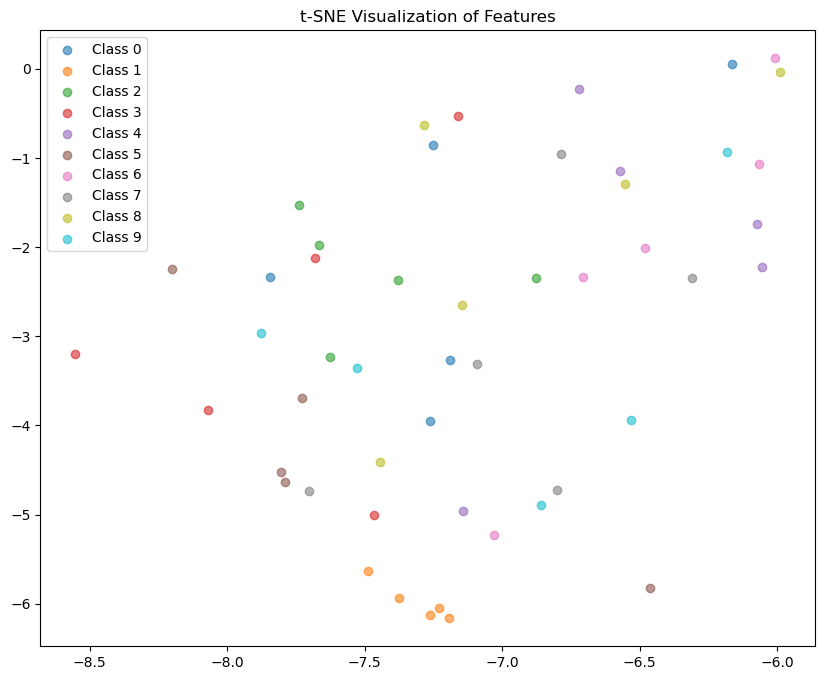

Epoch [6/100]
Train Loss: 0.7633, Train Acc: 81.78%
Test Loss: 7.0734, Test Acc: 20.00%
Patience Counter: 2/10
Epoch [7/100]
Train Loss: 0.9081, Train Acc: 88.22%
Test Loss: 1.3540, Test Acc: 56.00%
Epoch [8/100]
Train Loss: 0.5356, Train Acc: 92.00%
Test Loss: 1.1358, Test Acc: 54.00%
Epoch [9/100]
Train Loss: 0.5716, Train Acc: 89.11%
Test Loss: 2.9563, Test Acc: 36.00%
Patience Counter: 1/10
Epoch [10/100]
Train Loss: 0.5649, Train Acc: 92.00%
Test Loss: 1.7375, Test Acc: 40.00%
Patience Counter: 2/10


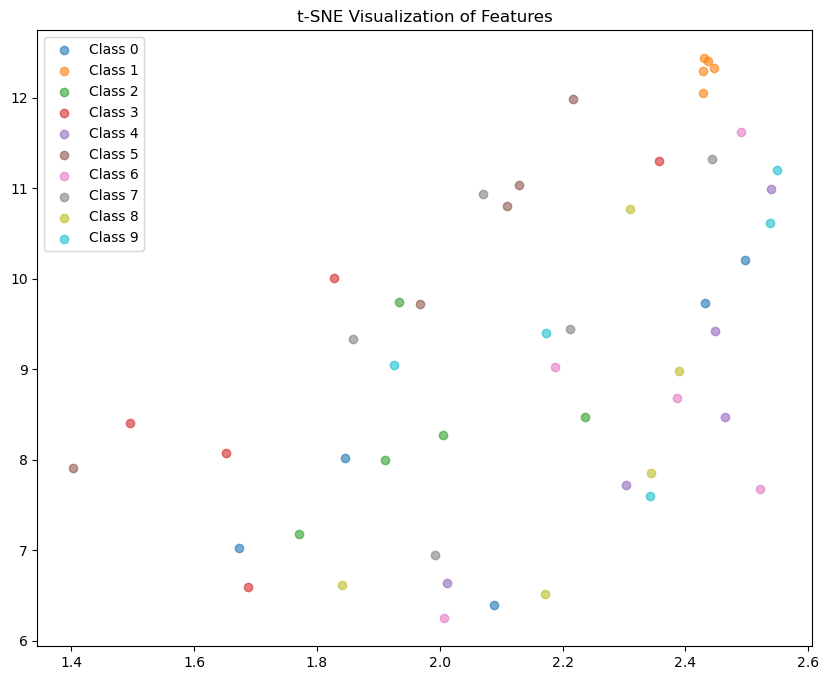

Epoch [11/100]
Train Loss: 0.4416, Train Acc: 92.22%
Test Loss: 1.4573, Test Acc: 54.00%
Patience Counter: 3/10
Epoch [12/100]
Train Loss: 0.5058, Train Acc: 93.33%
Test Loss: 0.6775, Test Acc: 82.00%
Epoch [13/100]
Train Loss: 0.4549, Train Acc: 90.22%
Test Loss: 3.9607, Test Acc: 24.00%
Patience Counter: 1/10
Epoch [14/100]
Train Loss: 0.3949, Train Acc: 95.11%
Test Loss: 3.8200, Test Acc: 30.00%
Patience Counter: 2/10
Epoch [15/100]
Train Loss: 0.3611, Train Acc: 93.11%
Test Loss: 0.6875, Test Acc: 82.00%
Patience Counter: 3/10


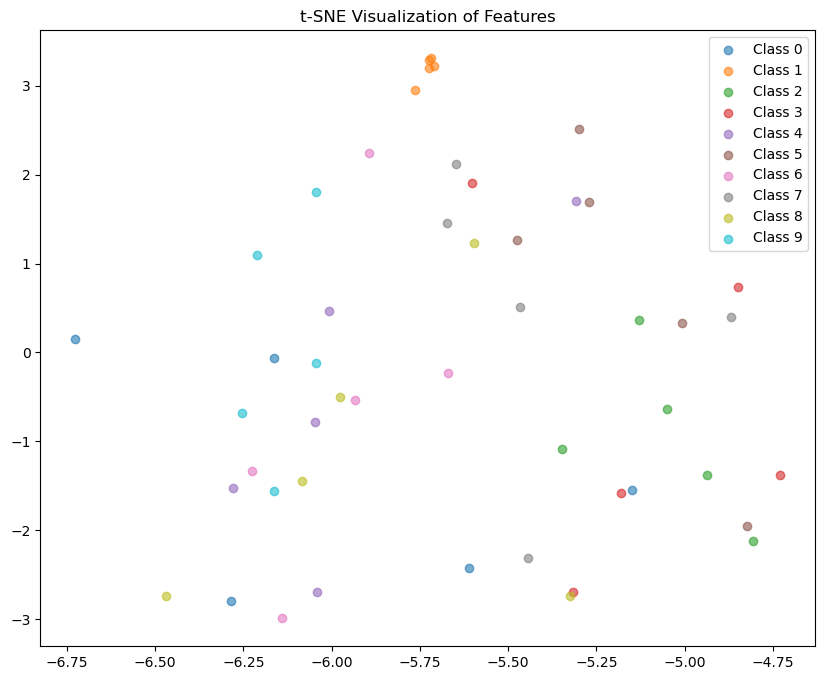

Epoch [16/100]
Train Loss: 0.3531, Train Acc: 95.11%
Test Loss: 0.9497, Test Acc: 72.00%
Patience Counter: 4/10
Epoch [17/100]
Train Loss: 0.4890, Train Acc: 93.56%
Test Loss: 0.7805, Test Acc: 76.00%
Patience Counter: 5/10
Epoch [18/100]
Train Loss: 0.4046, Train Acc: 90.67%
Test Loss: 1.5285, Test Acc: 52.00%
Patience Counter: 6/10
Epoch [19/100]
Train Loss: 0.5688, Train Acc: 92.22%
Test Loss: 3.9124, Test Acc: 32.00%
Patience Counter: 7/10
Epoch [20/100]
Train Loss: 0.3490, Train Acc: 93.33%
Test Loss: 0.6194, Test Acc: 74.00%


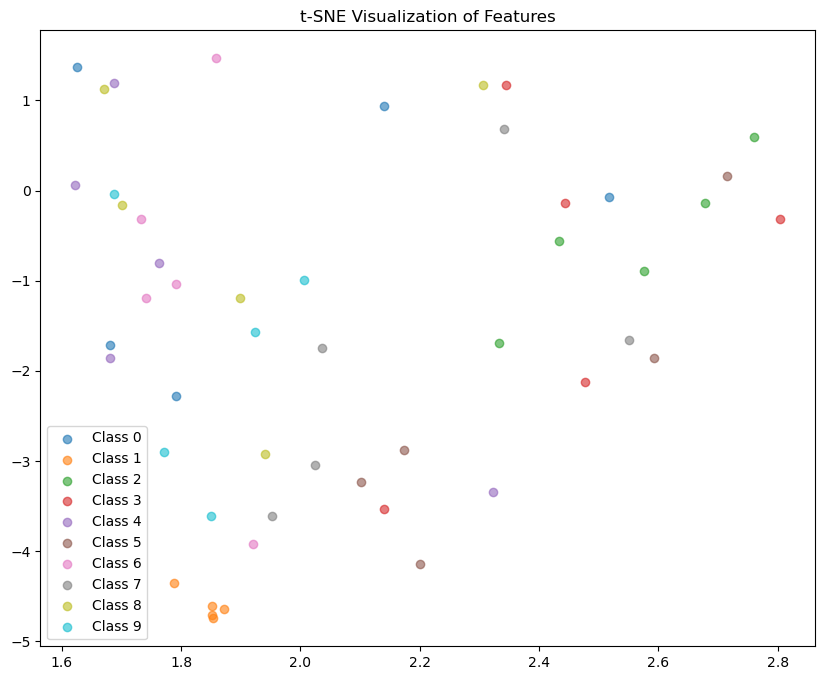

Epoch [21/100]
Train Loss: 0.3029, Train Acc: 94.89%
Test Loss: 0.7269, Test Acc: 74.00%
Patience Counter: 1/10
Epoch [22/100]
Train Loss: 0.2854, Train Acc: 96.22%
Test Loss: 0.8449, Test Acc: 82.00%
Patience Counter: 2/10
Epoch [23/100]
Train Loss: 0.2822, Train Acc: 96.22%
Test Loss: 0.5830, Test Acc: 80.00%
Epoch [24/100]
Train Loss: 0.3631, Train Acc: 97.11%
Test Loss: 0.3484, Test Acc: 92.00%
Epoch [25/100]
Train Loss: 0.5028, Train Acc: 96.89%
Test Loss: 0.9489, Test Acc: 72.00%
Patience Counter: 1/10


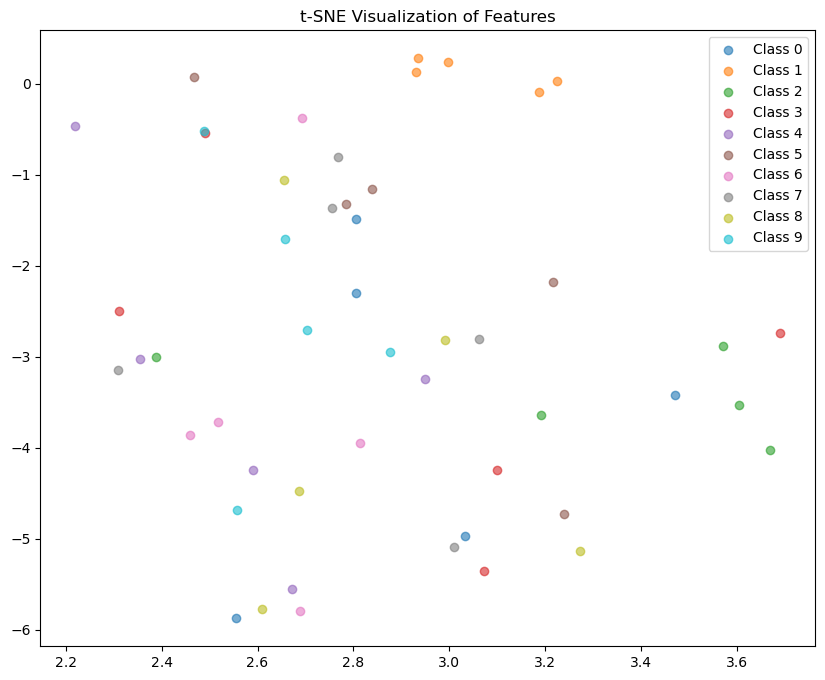

Epoch [26/100]
Train Loss: 0.2788, Train Acc: 96.22%
Test Loss: 1.0187, Test Acc: 70.00%
Patience Counter: 2/10
Epoch [27/100]
Train Loss: 0.2836, Train Acc: 97.11%
Test Loss: 0.6202, Test Acc: 80.00%
Patience Counter: 3/10
Epoch [28/100]
Train Loss: 0.5394, Train Acc: 96.22%
Test Loss: 0.3753, Test Acc: 90.00%
Patience Counter: 4/10
Epoch [29/100]
Train Loss: 0.1716, Train Acc: 98.44%
Test Loss: 0.2916, Test Acc: 90.00%
Epoch [30/100]
Train Loss: 0.1251, Train Acc: 98.00%
Test Loss: 0.3443, Test Acc: 92.00%
Patience Counter: 1/10


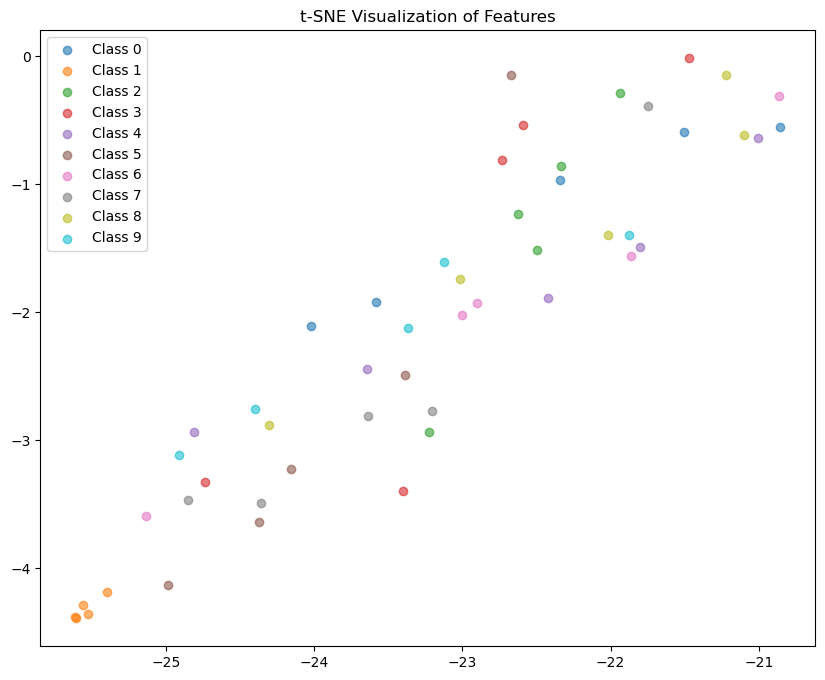

Epoch [31/100]
Train Loss: 0.1534, Train Acc: 98.67%
Test Loss: 0.3614, Test Acc: 88.00%
Patience Counter: 2/10
Epoch [32/100]
Train Loss: 0.1577, Train Acc: 98.89%
Test Loss: 0.3359, Test Acc: 92.00%
Patience Counter: 3/10
Epoch [33/100]
Train Loss: 0.2802, Train Acc: 98.89%
Test Loss: 0.3255, Test Acc: 90.00%
Patience Counter: 4/10
Epoch [34/100]
Train Loss: 0.2317, Train Acc: 98.00%
Test Loss: 0.2946, Test Acc: 90.00%
Patience Counter: 5/10
Epoch [35/100]
Train Loss: 0.1423, Train Acc: 99.11%
Test Loss: 0.2904, Test Acc: 92.00%


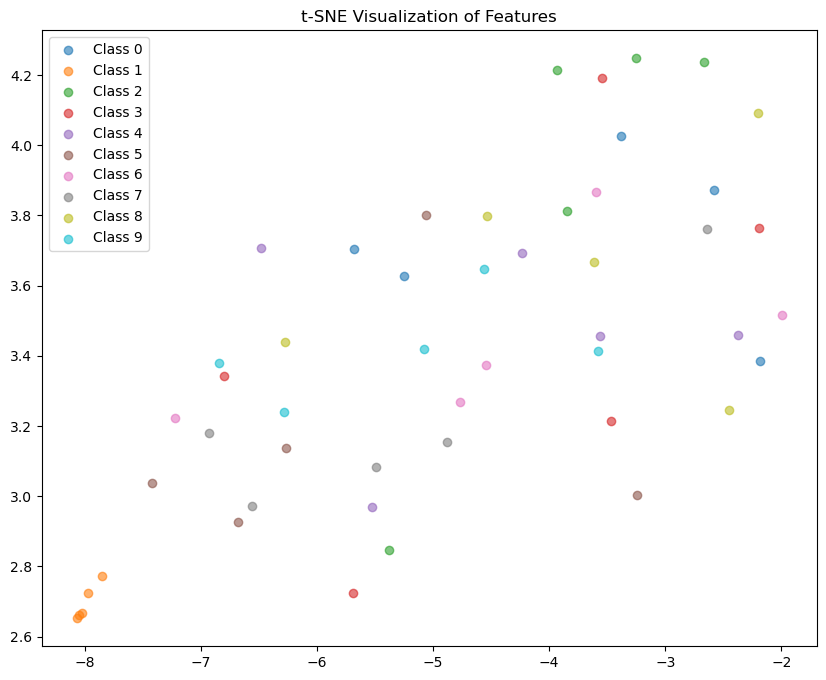

Epoch [36/100]
Train Loss: 0.1715, Train Acc: 98.67%
Test Loss: 0.2763, Test Acc: 92.00%
Epoch [37/100]
Train Loss: 0.2080, Train Acc: 98.89%
Test Loss: 0.3023, Test Acc: 92.00%
Patience Counter: 1/10
Epoch [38/100]
Train Loss: 0.1340, Train Acc: 99.78%
Test Loss: 0.2309, Test Acc: 90.00%
Epoch [39/100]
Train Loss: 0.1613, Train Acc: 99.56%
Test Loss: 0.2292, Test Acc: 88.00%
Epoch [40/100]
Train Loss: 0.1129, Train Acc: 98.89%
Test Loss: 0.2584, Test Acc: 90.00%
Patience Counter: 1/10


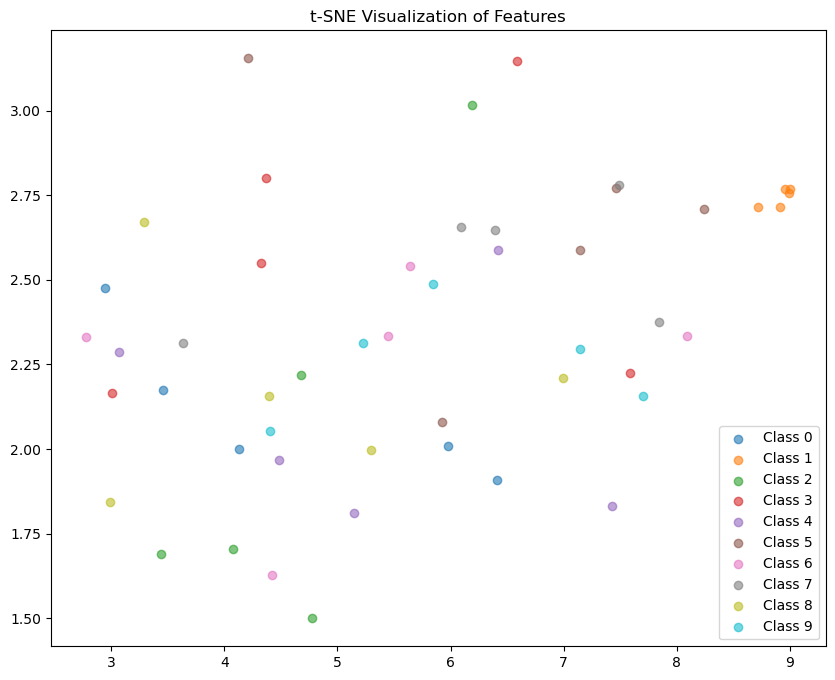

Epoch [41/100]
Train Loss: 0.1531, Train Acc: 99.33%
Test Loss: 0.2648, Test Acc: 92.00%
Patience Counter: 2/10
Epoch [42/100]
Train Loss: 0.1201, Train Acc: 99.33%
Test Loss: 0.2608, Test Acc: 90.00%
Patience Counter: 3/10
Epoch [43/100]
Train Loss: 0.1104, Train Acc: 99.33%
Test Loss: 0.2570, Test Acc: 92.00%
Patience Counter: 4/10
Epoch [44/100]
Train Loss: 0.0882, Train Acc: 99.33%
Test Loss: 0.2532, Test Acc: 94.00%
Patience Counter: 5/10
Epoch [45/100]
Train Loss: 0.0876, Train Acc: 99.78%
Test Loss: 0.2477, Test Acc: 94.00%
Patience Counter: 6/10


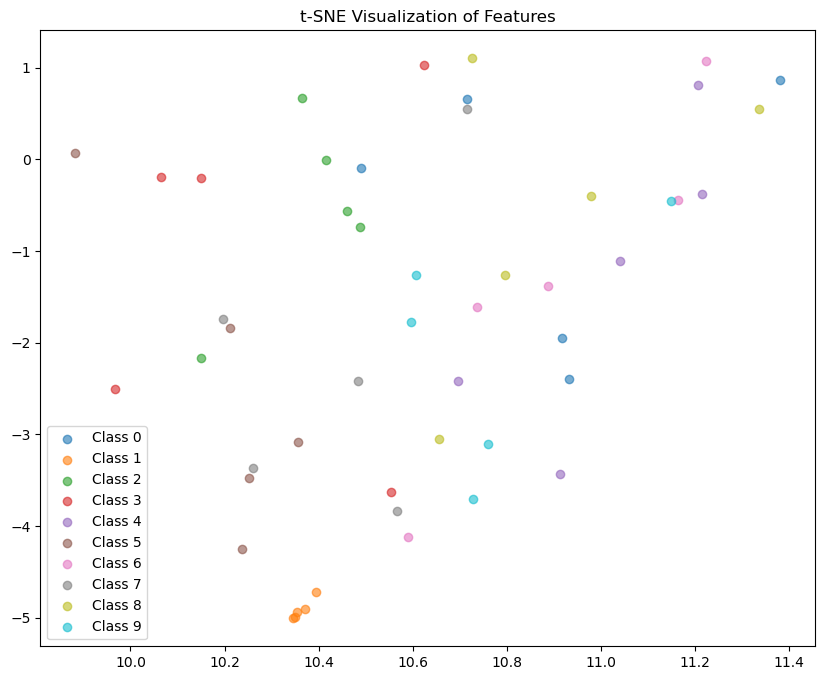

Epoch [46/100]
Train Loss: 0.1189, Train Acc: 99.56%
Test Loss: 0.2446, Test Acc: 94.00%
Patience Counter: 7/10
Epoch [47/100]
Train Loss: 0.1450, Train Acc: 99.78%
Test Loss: 0.2155, Test Acc: 94.00%
Epoch [48/100]
Train Loss: 0.0916, Train Acc: 99.56%
Test Loss: 0.2083, Test Acc: 96.00%
Epoch [49/100]
Train Loss: 0.1583, Train Acc: 99.56%
Test Loss: 0.2190, Test Acc: 92.00%
Patience Counter: 1/10
Epoch [50/100]
Train Loss: 0.2979, Train Acc: 98.89%
Test Loss: 0.2380, Test Acc: 92.00%
Patience Counter: 2/10


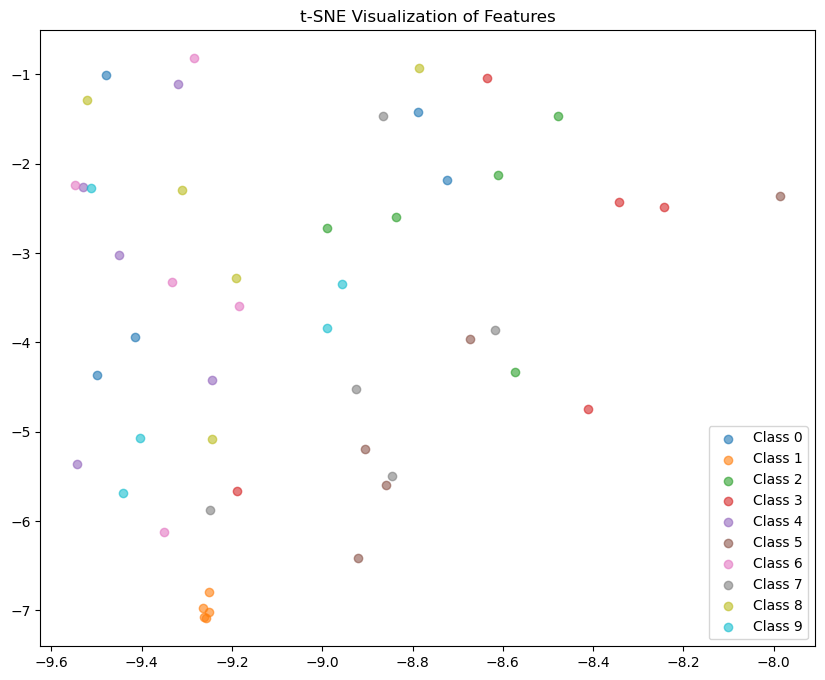

Epoch [51/100]
Train Loss: 0.1099, Train Acc: 99.78%
Test Loss: 0.2339, Test Acc: 92.00%
Patience Counter: 3/10
Epoch [52/100]
Train Loss: 0.0684, Train Acc: 99.78%
Test Loss: 0.2561, Test Acc: 92.00%
Patience Counter: 4/10
Epoch [53/100]
Train Loss: 0.1040, Train Acc: 99.78%
Test Loss: 0.2513, Test Acc: 92.00%
Patience Counter: 5/10
Epoch [54/100]
Train Loss: 0.1128, Train Acc: 99.56%
Test Loss: 0.2542, Test Acc: 92.00%
Patience Counter: 6/10
Epoch [55/100]
Train Loss: 0.1010, Train Acc: 100.00%
Test Loss: 0.2563, Test Acc: 92.00%
Patience Counter: 7/10


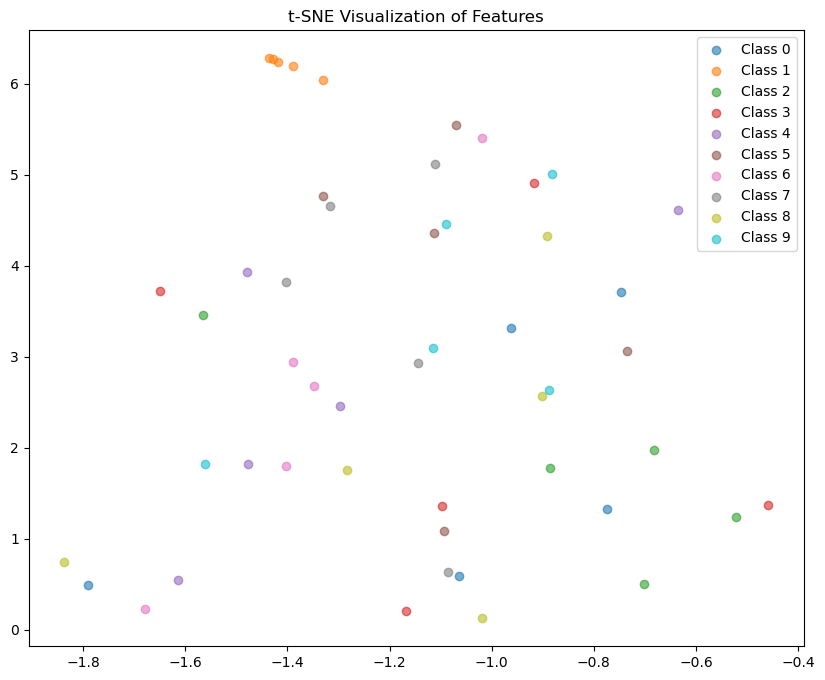

Epoch [56/100]
Train Loss: 0.1039, Train Acc: 99.56%
Test Loss: 0.2467, Test Acc: 92.00%
Patience Counter: 8/10
Epoch [57/100]
Train Loss: 0.3499, Train Acc: 99.11%
Test Loss: 0.2652, Test Acc: 94.00%
Patience Counter: 9/10
Epoch [58/100]
Train Loss: 0.0888, Train Acc: 99.78%
Test Loss: 0.2528, Test Acc: 94.00%
Patience Counter: 10/10
Early stopping at epoch 58


In [6]:
# 학습 루프
for epoch in range(100):
    # Training Loop
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # Evaluation Loop
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    test_loss = test_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/100]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # 학습률 조정 (ReduceLROnPlateau 사용)
    scheduler.step(test_loss)  # test_loss를 전달하여 학습률을 조정

    # Early Stopping 체크
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0  # 개선이 있었으므로 카운터 초기화
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{early_stopping_patience}")

    # 만약 patience_counter가 early_stopping_patience 이상이면 조기 종료
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # t-SNE Visualization (5 epoch마다 실행)
    if (epoch + 1) % 5 == 0:
        test_features, test_labels = extract_features(model, test_loader, device)
        plot_tsne(test_features, test_labels, num_classes=10)

# base 기반으로 latent space의 중요성을 확인하는 방법에 대한 검증

- 새로운 분류기를 정의하고 이를 Latent Space 기반으로 학습 및 평가

In [23]:
# Latent Space 기반 분류기 정의
class LatentClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)


In [24]:
# Latent Feature 추출
train_features, train_labels = extract_features(model, train_loader, device)
test_features, test_labels = extract_features(model, test_loader, device)

# TensorDataset으로 변환
train_features = torch.tensor(train_features, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

train_dataset_latent = torch.utils.data.TensorDataset(train_features, train_labels)
test_dataset_latent = torch.utils.data.TensorDataset(test_features, test_labels)

# DataLoader 생성
train_loader_latent = torch.utils.data.DataLoader(train_dataset_latent, batch_size=64, shuffle=True)
test_loader_latent = torch.utils.data.DataLoader(test_dataset_latent, batch_size=64, shuffle=False)


OutOfMemoryError: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 23.64 GiB of which 254.38 MiB is free. Including non-PyTorch memory, this process has 22.90 GiB memory in use. Of the allocated memory 22.21 GiB is allocated by PyTorch, and 496.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

- 추가 부분: Latent Feature 추출 및 DataLoader 구성
- 기존 학습 완료된 모델에서 Latent Space의 Feature를 추출하고, 새로운 DataLoader를 구성.

In [25]:
# Latent Feature 추출
train_features, train_labels = extract_features(model, train_loader, device)
test_features, test_labels = extract_features(model, test_loader, device)

# TensorDataset으로 변환
train_features = torch.tensor(train_features, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

train_dataset_latent = torch.utils.data.TensorDataset(train_features, train_labels)
test_dataset_latent = torch.utils.data.TensorDataset(test_features, test_labels)

# DataLoader 생성
train_loader_latent = torch.utils.data.DataLoader(train_dataset_latent, batch_size=64, shuffle=True)
test_loader_latent = torch.utils.data.DataLoader(test_dataset_latent, batch_size=64, shuffle=False)


OutOfMemoryError: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 23.64 GiB of which 272.75 MiB is free. Including non-PyTorch memory, this process has 22.90 GiB memory in use. Of the allocated memory 22.21 GiB is allocated by PyTorch, and 496.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

- 추가 부분: Latent Classifier 학습
- Latent Space에서 추출한 Feature를 기반으로 새로운 분류기를 학습 및 평가.


In [ ]:
# Latent Classifier 학습
latent_classifier = LatentClassifier(input_dim=train_features.shape[1], num_classes=10).to(device)
criterion_latent = nn.CrossEntropyLoss()
optimizer_latent = optim.Adam(latent_classifier.parameters(), lr=0.001)

# 학습 Loop
num_epochs = 50
for epoch in range(num_epochs):
    # Training Loop
    latent_classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    for features, labels in train_loader_latent:
        features, labels = features.to(device), labels.to(device)

        optimizer_latent.zero_grad()
        outputs = latent_classifier(features)
        loss = criterion_latent(outputs, labels)
        loss.backward()
        optimizer_latent.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader_latent)

    # Evaluation Loop
    latent_classifier.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for features, labels in test_loader_latent:
            features, labels = features.to(device), labels.to(device)
            outputs = latent_classifier(features)
            loss = criterion_latent(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    test_loss = test_loss / len(test_loader_latent)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
